In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Forest\ Fire

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1p7r_LRybJ5dhRzYAQ9bq6ZZsHt3nNiHV/Forest Fire


In [ ]:
!pip install scprep
!pip install phate

     |████████████████████████████████| 102kB 4.2MB/s 
     |████████████████████████████████| 419kB 5.9MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 1.8MB 13.8MB/s 


In [ ]:
import numpy as np
import scipy
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import networkx as nx
import community as community_louvain
import pandas
import sklearn
import scprep
import math
from itertools import permutations 
import sys
import pandas as pd
import random
import matplotlib.pyplot as plt
from ps1_functions import compute_distances, compute_affinity_matrix, diff_map_info, get_diff_map
from ps2_functions import load_json_files, sbm, L, SC, compute_fourier_basis, gft, igft, filterbank_matrix, kmeans, kmeans_plusplus
import phate
%matplotlib inline

## SBM Gaussian Mixture

### Constructing the model

In [ ]:
A, gt, coords = sbm(500, 6,  2/100, 1/5, 0.16)
# TO DO: change in ps2_functions.py so A & gt are already zero-indexed
A = A.astype(int)
gt = gt.astype(int) - 1 # Make zero-indexed
sbm_dist = compute_distances(coords) 
sbm_affin = compute_affinity_matrix(sbm_dist, kernel_type='adaptive', k=15)
print(sbm_affin)

[[1.00000000e+000 5.83155925e-140 1.54810227e-150 ... 2.28845158e-032
  5.26031270e-002 6.30942404e-013]
 [5.83155925e-140 1.00000000e+000 5.34808442e-001 ... 4.26755585e-129
  3.31185199e-062 4.17929888e-033]
 [1.54810227e-150 5.34808442e-001 1.00000000e+000 ... 6.83051721e-120
  4.59379541e-067 1.21581629e-036]
 ...
 [2.28845158e-032 4.26755585e-129 6.83051721e-120 ... 1.00000000e+000
  1.12563715e-020 2.69410078e-002]
 [5.26031270e-002 3.31185199e-062 4.59379541e-067 ... 1.12563715e-020
  1.00000000e+000 8.33144075e-014]
 [6.30942404e-013 4.17929888e-033 1.21581629e-036 ... 2.69410078e-002
  8.33144075e-014 1.00000000e+000]]


Calculating PHATE...
  Running PHATE on 500 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.21 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 0.13 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.07 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.28 seconds.
Calculated PHATE in 0.70 seconds.


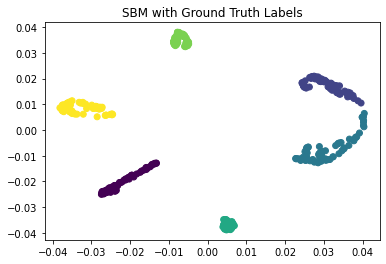

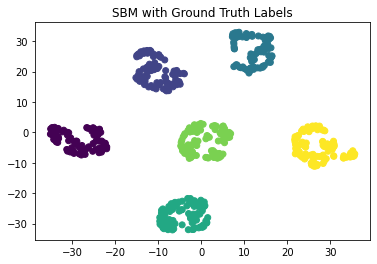

In [ ]:
phate_op = phate.PHATE()
phate_embedded = phate_op.fit_transform(sbm_affin)
plt.figure()
plt.scatter(phate_embedded[:,0], phate_embedded[:,1], c=gt);
plt.title("SBM with Ground Truth Labels")
plt.show();

tsne_embedded = TSNE(n_components=2).fit_transform(sbm_affin)
plt.figure()
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=gt);
plt.title("SBM with Ground Truth Labels")
plt.show();

### Runnning Forest Fire Model

In [18]:
# parameters
A = sbm_affin
fire_temp = 1
#flash_point = 1
heat_list = [] # Storing heat of successive points as they ignite

# initialization
n_points = A.shape[0] #the number of entries/data points
n_label_list = -np.ones(n_points) #a list of labels for each point
remaining_points = n_points
num_label = 0 # cluster index
first_flint = True
centroids = []

while (remaining_points > 0): #iterate until there is a label for each point
    if first_flint == True:
        flint = random.randint(0, remaining_points-1) #choose a random point to start a fire
        first_flint = False
    else:
        # Every element of list is a vector of distances from each point to a centroid
        dists = [np.sum(np.square(A - c), axis=1) for c in centroids]
        min_dists = np.min(dists, axis=0)
        min_dists_adjusted = min_dists * (n_label_list < 0)  # Set distance to 0 if already burnt
        # Samples a point w prob proportional to distance to closest centroid
        flint = np.random.choice(np.arange(n_points), size = 1, p = min_dists_adjusted / sum(min_dists_adjusted))[0]        

        
    print("flint selected: " + str(flint))
        
    remaining_points = remaining_points - 1
    n_label_list[flint] = num_label    
    centroids.append(A[flint, :])
    
    # burning_list = [flint] # indices of burning points
    # while len(burning_list) != 0:
    #     flint_neighbors = A[burning_list[0], :] # neighbors of first point on fire
    #     for idx in range(len(flint_neighbors)):
    #         if n_label_list[idx] == -1: #check if node is labeled
    #             threshold = 1 / np.sum(A[idx, :]) #calculate the threshold by flash_point / degree
    #             heat = np.mean(fire_temp * A[n_label_list == num_label, idx]) #calculate the heat by fire_temp * affinity
    #             if heat > threshold:
    #                 burning_list.append(burning_list[0]) #reconsider neighbors of current burning node
    #                 burning_list.append(idx) #consider neighbors of current node's neighbor
    #                 print(fire_temp, A[n_label_list == num_label, idx]) 
    #                 print(" burned node ", idx)
    #                 print(" " + str(burning_list[0]) + "-" + str(idx) + \
    #                     "|heat: " + str(heat) + \
    #                     "|threshold: " + str(threshold))
    #                 remaining_points = remaining_points - 1
    #                 heat_list.append(heat)
    #                 n_label_list[idx] = num_label # Burning -> set to 0
    #     burning_list = burning_list[1:]
        
    # Jeremy's parallelization 11/13. The main difference is that it doesn't add newly 
    # burnt points as it loops through all the neighbors of a point
    burning_list = np.array([flint])
    while burning_list.shape[0] > 0:
        flint_neighbors = A[burning_list[0], :] # neighbors of first point on fire
        threshold = 1 / np.sum(A, axis=1) #calculate the threshold by flash_point / degree
        heat = np.mean(fire_temp * A[n_label_list == num_label, :], axis=0)
        true_indices = np.argwhere(np.logical_and(heat > threshold, n_label_list==-1))
        true_indices = np.reshape(true_indices, (true_indices.shape[0],))
        if true_indices.shape[0] > 0:
            burning_list = np.append(burning_list, burning_list[0])
            burning_list = np.append(burning_list, true_indices)
        burning_list = burning_list[1:]
        remaining_points = remaining_points - true_indices.shape[0]
        heat_list.append(heat)
        n_label_list[true_indices] = num_label # Burning -> set to 0

    num_label = num_label + 1
    
# reorganize labels
unique_labels = np.unique(n_label_list)
output_labels = -np.ones(n_points)
for idx, u in enumerate(unique_labels):
    output_labels[n_label_list==u] = idx
output_labels = output_labels.astype(int)

flint selected: 428
flint selected: 125
flint selected: 111
flint selected: 236
flint selected: 87
flint selected: 90
flint selected: 352


[0 1 2 3 4 5 6]


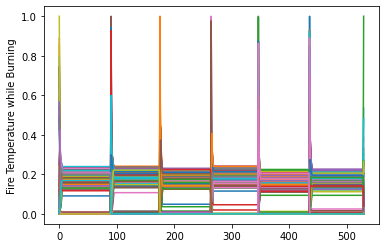

In [19]:
print(np.unique(output_labels))
plt.plot(heat_list)
plt.ylabel('Fire Temperature while Burning')
plt.show()

In [20]:
def forest_fire_clustering(A, fire_temp=20, distance=np.linalg.norm):
    '''
    Forest Fire Clustering (by Flynn Chen & Jeremy Goldwasser)

    Inputs:
        A   (N x N np.ndarray): Adjacency matrix of graph

    Outputs:
        output_labels (n x 1 np.ndarray): Output cluster labels
    '''
    
    # initialization
    n_points = A.shape[0] #the number of entries/data points
    n_label_list = -np.ones(n_points) # Fills up with burn labels for each point
    remaining_points = n_points
    num_label = 0 # cluster index
    first_flint = True
    centroids = []

    while (remaining_points > 0): #iterate until there is a label for each point
        if first_flint == True:
            flint = random.randint(0, remaining_points-1) #choose a random point to start a fire
            first_flint = False
        else:
            # Chooses point to start next fire with K-Means++
            # Every element of list is a vector of distances from each point to a centroid
            dists = [np.sum(np.square(A - c), axis=1) for c in centroids]
            min_dists = np.min(dists, axis=0)
            min_dists_adjusted = min_dists * (n_label_list < 0)  # Set distance to 0 if already burnt
            # Samples a point w prob proportional to distance to closest centroid
            flint = np.random.choice(np.arange(n_points), size = 1, p = min_dists_adjusted / sum(min_dists_adjusted))[0]        

            # dist = [] # Stores each not-on-fire point's distance to nearest centroid
            # for i in range(n_points):
            #     if n_label_list[i] >= 0:
            #         dist.append(0)
            #     else:
            #         ## compute distance of 'point' from each of the previously 
            #         ## selected centroid and store the minimum distance 
            #         d = sys.maxsize
            #         for j in range(len(centroids)): # We can definitely vectorize this somehow
            #             temp_dist = np.linalg.norm(A[i, :] - centroids[j]) # Using adjacency as a proxy for distance. try other methods!
            #             d = min(d, temp_dist) 
            #         dist.append(d)

            # ## select data point with probability 
            # ## proportional to the current flint distance as our next centroid 
            # dist = np.array(dist)
            # flint = np.random.choice(np.arange(len(dist)), size = 1, p = dist / sum(dist))[0]
            # dist = []

        print("flint selected: " + str(flint))

        remaining_points = remaining_points - 1 # number of unburnt points
        n_label_list[flint] = num_label    
        centroids.append(A[flint, :]) # Entry is adjacencies for each flint point
        burning_list = [flint]
        
        # Burn a cluster
        while len(burning_list) != 0:
            flint_neighbors = A[burning_list[0], :] #point on fire
            for idx in range(len(flint_neighbors)):
                if n_label_list[idx] == -1: #check if node is labeled
                    threshold = 1 / np.sum(A[idx, :]) #calculate the threshold by flash_point / degree
                    # Heat is fire_temp * proportion of points burning in this cluster that are neighbors of idx
                    heat = np.mean(fire_temp * A[n_label_list == num_label, idx])
                    if heat > threshold: # ignite!
                        burning_list.append(burning_list[0]) #reconsider neighbors of current burning node
                        burning_list.append(idx) #consider neighbors of current node's neighbor
                        print(fire_temp, A[n_label_list == num_label, idx]) 
                        print(" burned node ", idx)
                        print(" " + str(burning_list[0]) + "-" + str(idx) + \
                            "|heat: " + str(heat) + \
                            "|threshold: " + str(threshold))
                        remaining_points = remaining_points - 1
                        heat_list.append(heat)
                        n_label_list[idx] = num_label
            burning_list = burning_list[1:]

        num_label = num_label + 1

    # reorganize labels
    unique_labels = np.unique(n_label_list)
    output_labels = -np.ones(n_points)
    for idx, u in enumerate(unique_labels):
        output_labels[n_label_list==u] = idx
        
    return output_labels.astype(int)

In [21]:
# In preparation for comparison with gt, takes k largest clusters
k_gt = np.unique(gt).shape[0]

# Gets labels of smallest clusters
unique, counts = np.unique(output_labels, return_counts=True)
bad_indices = np.argsort(counts)[:counts.shape[0]-k_gt] # indices of labels of small clusters
common_labels = np.delete(unique, bad_indices)
print('k Most Common Labels: ' + str(common_labels))

# Removes points in smallest clusters
good_output_indices = np.array([output in common_labels for output in output_labels])
good_outputs = output_labels[good_output_indices]
good_gt = gt[good_output_indices]

k Most Common Labels: [0 1 2 3 4 5]


In [22]:
# Finds which predicted labels occur most frequently for each true cluster
likeliest_gt = []
for i in range(k_gt):
    label = common_labels[i]
    gt_with_label = good_gt[good_outputs==label] # Only gt points with that predicted label
    unique_, counts_ = np.unique(gt_with_label, return_counts=True) # counts of which gt labels correspond to output val
    likeliest_gt.append(unique_[np.argmax(counts_)])
    
# Maps labels
perms = list(permutations(range(k_gt)))
n_good = good_gt.shape[0]
mapped_labels = np.repeat(-1,n_good) # initialize
likeliest_gt = [3]
if tuple(likeliest_gt) in perms:
    # Valid mapping. Switch elements
    print('Label Mapping: '+str(likeliest_gt))
    for i in range(k_gt):
        idx = good_outputs==common_labels[i]
        mapped_labels[idx] = likeliest_gt[i]
else: 
    # Find best mapping by exhaustively iterating through all permutations
    mapped_labels=None
    best_num_correct=-1
    best_perm = None
    if k_gt < 10:
        print('Exhaustively searching through all permutations to find optimal mapping. This can take up to a minute when k or n is large.')
        count = 0
        for perm in perms:
            mapping = np.repeat(-1, n_good) # initialize
            # Switch elements according to that permutation
            for i in range(k_gt):
                idx = good_outputs==common_labels[i]
                mapping[idx]=perm[i]

            # Compute score of perm
            num_correct = np.sum(mapping == good_gt)
            if num_correct > best_num_correct:
                mapped_labels=mapping
                best_num_correct = num_correct
                best_perm = perm
            count += 1
            if i % 10000==0:
                print(count)
        print('Label Mapping: '+str(best_perm))
    else:
        print("Unable to map predicted labels onto ground truth.")


Exhaustively searching through all permutations to find optimal mapping. This can take up to a minute when k or n is large.
Label Mapping: (1, 0, 3, 2, 4, 5)


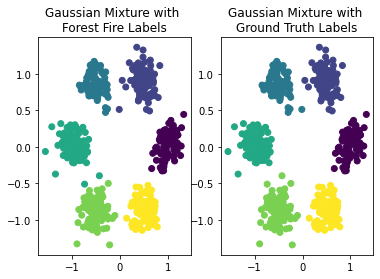

Percent Correct = 99.2%


In [23]:
if mapped_labels is not None:
    good_coords = coords[good_output_indices,:]

    plt.subplot(1, 2, 1)
    plt.scatter(good_coords[:,0], good_coords[:,1], c=mapped_labels)
    plt.title("Gaussian Mixture with \nForest Fire Labels")
    plt.subplot(1, 2, 2)
    plt.scatter(good_coords[:,0], good_coords[:,1], c=good_gt);
    plt.title("Gaussian Mixture with \nGround Truth Labels")
    plt.show()

    # Compute percent accuracy
    pct_correct = np.sum(mapped_labels == good_gt)/n_points*100
    print("Percent Correct = {}%".format(round(pct_correct,3)))

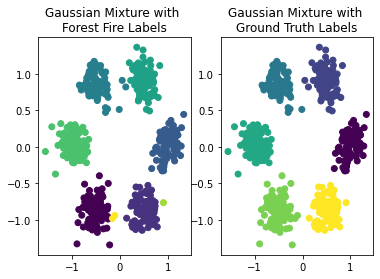

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(coords[:,0], coords[:,1], c=output_labels);
plt.title("Gaussian Mixture with \nForest Fire Labels")
plt.subplot(1, 2, 2)
plt.scatter(coords[:,0], coords[:,1], c=gt);
plt.title("Gaussian Mixture with \nGround Truth Labels")
plt.show();

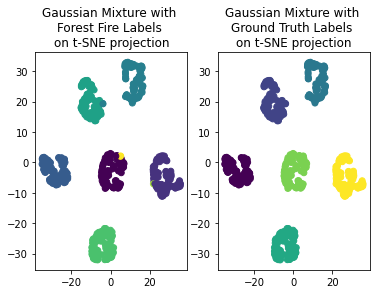

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=output_labels);
plt.title("Gaussian Mixture with \nForest Fire Labels \non t-SNE projection")
plt.subplot(1, 2, 2)
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=gt);
plt.title("Gaussian Mixture with \nGround Truth Labels \non t-SNE projection")
plt.show();

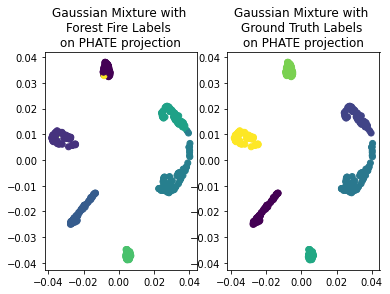

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(phate_embedded[:,0], phate_embedded[:,1], c=output_labels);
plt.title("Gaussian Mixture with \nForest Fire Labels \non PHATE projection")
plt.subplot(1, 2, 2)
plt.scatter(phate_embedded[:,0], phate_embedded[:,1], c=gt);
plt.title("Gaussian Mixture with \nGround Truth Labels \non PHATE projection")
plt.show();

### Permutation & Uncertainty Evaluation

In [ ]:
# parameters
output_labels = output_labels
A = sbm_affin
fire_temp = 1
#flash_point = 1

# initialization
n_points = A.shape[0] #the number of entries/data points
num_permute = 200
n_label_list = -np.ones((n_points, num_permute)) # Fills up labeling points with their burn clusters

for p in range(num_permute): #perform permutation test
    
    random_label_order = np.unique(output_labels)
    np.random.shuffle(random_label_order)
    for num_label in random_label_order:
        
        #randomly select a flint from the cluster
        cluster_node_idx = np.where(output_labels == num_label)[0]
        flint = np.random.choice(cluster_node_idx, 1)[0]
        if (p % 10 == 0):
            print(p, "flint selected: " + str(flint) + " in cluster ", num_label )
        
        #start propogation there
        n_label_list[flint, p] = num_label
        burning_list = [flint]

        while len(burning_list) != 0:

            flint_neighbors = A[burning_list[0], :] #point on fire
            for idx in range(len(flint_neighbors)):
                if n_label_list[idx, p] == -1: #check if node is labeled
                    threshold = 1 / np.sum(A[idx, :]) #calculate the threshold by flash_point / degree
                    heat = np.mean(fire_temp * A[n_label_list[:, p] == num_label, idx]) #calculate the heat by fire_temp * affinity
                    if heat > threshold: # Ignite point
                        burning_list.append(burning_list[0]) #reconsider neighbors of current burning node
                        burning_list.append(idx) #consider neighbors of current node's neighbor
                        #print(fire_temp, A[n_label_list[:, p] == num_label, idx]) 
                        #print(" burned node ", idx, " in cluster ", num_label)
                        #print(" " + str(burning_list[0]) + "-" + str(idx) + \
                        #  "|heat: " + str(heat) + \
                        #  "|threshold: " + str(threshold))
                        n_label_list[idx, p] = num_label

            burning_list = burning_list[1:]

0 flint selected: 72 in cluster  3
0 flint selected: 371 in cluster  4
0 flint selected: 453 in cluster  7
0 flint selected: 352 in cluster  6
0 flint selected: 286 in cluster  2
0 flint selected: 277 in cluster  0
0 flint selected: 139 in cluster  5
0 flint selected: 45 in cluster  1
10 flint selected: 352 in cluster  6
10 flint selected: 154 in cluster  1
10 flint selected: 215 in cluster  2
10 flint selected: 107 in cluster  0
10 flint selected: 373 in cluster  4
10 flint selected: 453 in cluster  7
10 flint selected: 184 in cluster  5
10 flint selected: 67 in cluster  3
20 flint selected: 443 in cluster  5
20 flint selected: 315 in cluster  2
20 flint selected: 132 in cluster  3
20 flint selected: 420 in cluster  4
20 flint selected: 417 in cluster  1
20 flint selected: 352 in cluster  6
20 flint selected: 225 in cluster  7
20 flint selected: 188 in cluster  0
30 flint selected: 3 in cluster  2
30 flint selected: 406 in cluster  0
30 flint selected: 225 in cluster  7
30 flint selec

KeyboardInterrupt: ignored

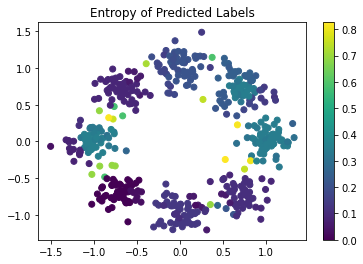

In [ ]:
entropy_list = []
for i in range(n_label_list.shape[0]): #iterate over every data point
    data_labels = n_label_list[i, :]
    labeled_data = data_labels[data_labels >= 0].astype(int)
    spread = np.bincount(labeled_data) / np.sum(np.bincount(labeled_data))
    node_entropy = scipy.stats.entropy(spread)
    entropy_list.append(node_entropy)
#print(entropy_list)

plt.scatter(coords[:,0], coords[:,1], c=np.array(entropy_list));
plt.title("Entropy of Predicted Labels")
plt.colorbar()
plt.show();

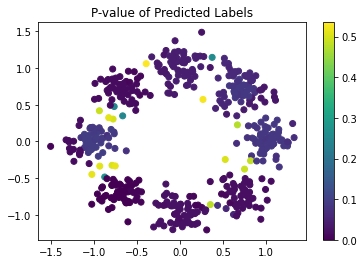

In [ ]:
pval_list = []
for i in range(n_label_list.shape[0]): #iterate over every data point
    data_labels = n_label_list[i, :]
    labeled_data = data_labels[data_labels >= 0].astype(int)
    pval = 1 - np.mean(labeled_data == output_labels[i])
    pval_list.append(pval)
#print(pval_list)
pval_list = np.array(pval_list)
plt.scatter(coords[:,0], coords[:,1], c=pval_list);
plt.title("P-value of Predicted Labels")
plt.colorbar()
plt.show();

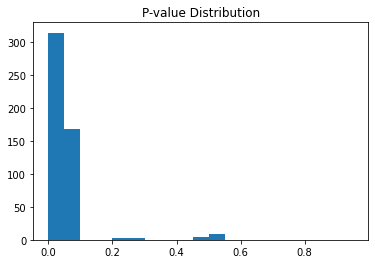

In [ ]:
plt.hist(pval_list, bins = np.arange(0.0, 1.0, 0.05)) 
plt.title("P-value Distribution") 
plt.show()

In [ ]:
# filter based on p-value
p_val_threshold = 0.2
significant_points = pval_list < p_val_threshold
A_filtered = A[significant_points, :]
A_filtered = A_filtered[:, significant_points]
print(A_filtered.shape)
filtered_output_labels = forest_fire_clustering(A_filtered, fire_temp=1)

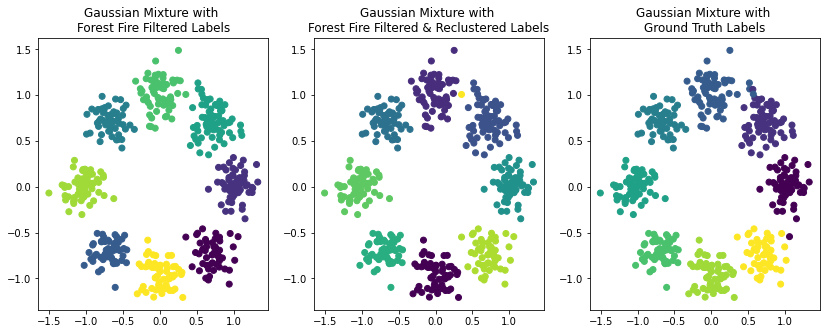

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.subplot(1, 3, 1)
plt.scatter(coords[significant_points,0], coords[significant_points,1], c=output_labels[significant_points]);
plt.title("Gaussian Mixture with \nForest Fire Filtered Labels")
plt.subplot(1, 3, 2)
plt.scatter(coords[significant_points,0], coords[significant_points,1], c=filtered_output_labels);
plt.title("Gaussian Mixture with \nForest Fire Filtered & Reclustered Labels")
plt.subplot(1, 3, 3)
plt.scatter(coords[significant_points,0], coords[significant_points,1], c=gt[significant_points]);
plt.title("Gaussian Mixture with \nGround Truth Labels")
plt.show();

In [ ]:
# parameters
filtered_output_labels = filtered_output_labels
fire_temp = 1
#flash_point = 1

# initialization
n_points = A_filtered.shape[0] #the number of entries/data points
num_permute = 200
n_label_list = -np.ones((n_points, num_permute)) #a list of labels for each point

for p in range(num_permute): #perform permutation test
    
    random_label_order = np.unique(filtered_output_labels)
    np.random.shuffle(random_label_order)
    for num_label in random_label_order:
        
        #randomly select a flint from the cluster
        cluster_node_idx = np.where(filtered_output_labels == num_label)[0]
        flint = np.random.choice(cluster_node_idx, 1)[0]
        if (p % 10 == 0):
            print(p, "flint selected: " + str(flint) + " in cluster ", num_label )
        
        #start propogation there
        n_label_list[flint, p] = num_label
        burning_list = [flint]

        while len(burning_list) != 0:

            flint_neighbors = A_filtered[burning_list[0], :] #point on fire
            for idx in range(len(flint_neighbors)):
                if n_label_list[idx, p] == -1: #check if node is labeled
                    threshold = 1 / np.sum(A_filtered[idx, :]) #calculate the threshold by flash_point / degree
                    heat = np.mean(fire_temp * A_filtered[n_label_list[:, p] == num_label, idx]) #calculate the heat by fire_temp * affinity
                    if heat > threshold:
                        burning_list.append(burning_list[0]) #reconsider neighbors of current burning node
                        burning_list.append(idx) #consider neighbors of current node's neighbor
                        #print(fire_temp, A_filtered[n_label_list[:, p] == num_label, idx]) 
                        #print(" burned node ", idx, " in cluster ", num_label)
                        #print(" " + str(burning_list[0]) + "-" + str(idx) + \
                        #  "|heat: " + str(heat) + \
                        #  "|threshold: " + str(threshold))
                        n_label_list[idx, p] = num_label

            burning_list = burning_list[1:]
            

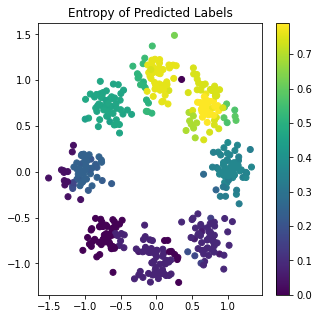

In [ ]:
rcParams['figure.figsize'] = 5, 5
entropy_filtered_list = []
for i in range(n_label_list.shape[0]): #iterate over every data point
    data_labels = n_label_list[i, :]
    labeled_data = data_labels[data_labels >= 0].astype(int)
    spread = np.bincount(labeled_data) / np.sum(np.bincount(labeled_data))
    node_entropy = scipy.stats.entropy(spread)
    entropy_filtered_list.append(node_entropy)
#print(entropy_filtered_list)
entropy_filtered_list = np.array(entropy_filtered_list)
plt.scatter(coords[significant_points,0], coords[significant_points,1], c=entropy_filtered_list);
plt.title("Entropy of Predicted Labels")
plt.colorbar()
plt.show();

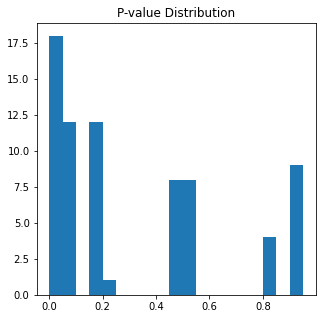

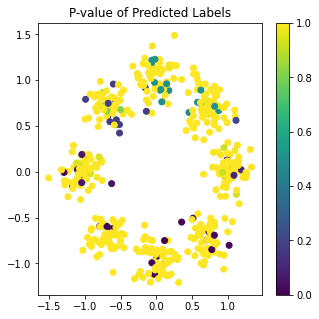

In [ ]:
pval_filtered_list = []
for i in range(n_label_list.shape[0]): #iterate over every data point
    data_labels = n_label_list[i, :]
    labeled_data = data_labels[data_labels >= 0].astype(int)
    pval = 1 - np.mean(labeled_data == output_labels[i])
    pval_filtered_list.append(pval)

pval_filtered_list = np.array(pval_filtered_list)
plt.hist(pval_filtered_list, bins = np.arange(0.0, 1.0, 0.05)) 
plt.title("P-value Distribution")
plt.show()

pval_filtered_list = np.array(pval_filtered_list)
plt.scatter(coords[significant_points,0], coords[significant_points,1], c=pval_filtered_list);
plt.title("P-value of Predicted Labels")
plt.colorbar()
plt.show();

### Exploring the c parameter space

0.08 263
0.28244897959183674 35
0.48489795918367345 24
0.6873469387755101 14
0.8897959183673468 9
1.0922448979591837 9
1.2946938775510204 8
1.497142857142857 5
1.6995918367346938 6
1.9020408163265305 5
2.1044897959183673 5
2.306938775510204 5
2.5093877551020407 3
2.711836734693877 3
2.914285714285714 4
3.116734693877551 3
3.3191836734693876 3
3.521632653061224 4
3.724081632653061 3
3.926530612244898 4
4.1289795918367345 3
4.331428571428571 4
4.533877551020408 3
4.736326530612245 3
4.938775510204081 2
5.141224489795918 2
5.343673469387754 3
5.546122448979592 2
5.748571428571428 2
5.951020408163265 2
6.153469387755102 2
6.355918367346939 2
6.558367346938775 2
6.760816326530612 2
6.963265306122448 2
7.1657142857142855 2
7.368163265306122 2
7.5706122448979585 2
7.773061224489796 2
7.975510204081632 2
8.177959183673469 2
8.380408163265306 2
8.582857142857142 2
8.78530612244898 2
8.987755102040817 2
9.190204081632652 2
9.39265306122449 2
9.595102040816325 2
9.797551020408163 2
10.0 2


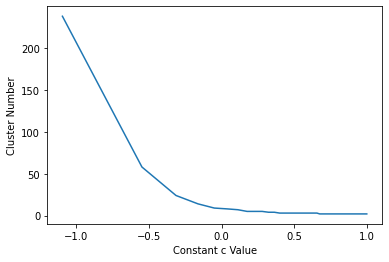

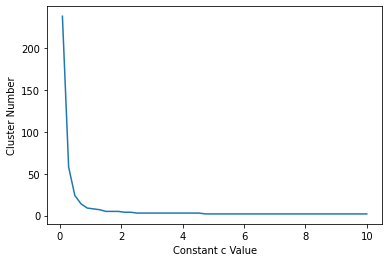

In [ ]:
cluster_number_list = []
for f in np.linspace(0.08, 10, num=50):

    # parameters
    A = sbm_affin
    fire_temp = f
    #flash_point = 1
    heat_list = []

    # initialization
    n_points = A.shape[0] #the number of entries/data points
    n_label_list = -np.ones(n_points) #a list of labels for each point
    remaining_points = n_points
    num_label = 0
    first_flint = True
    centroids = []

    while (remaining_points > 0): #iterate until there is a label for each point
        if first_flint == True:
            flint = random.randint(0, remaining_points-1) #choose a random point to start a fire
            first_flint = False
        else:
            dist = []
            for i in range(n_points):
                if n_label_list[i] >= 0:
                    dist.append(0)
                else:
                    ## compute distance of 'point' from each of the previously 
                    ## selected centroid and store the minimum distance 
                    d = sys.maxsize
                    for j in range(len(centroids)): 
                        temp_dist = np.linalg.norm(A[i, :] - centroids[j]) 
                        d = min(d, temp_dist) 
                    dist.append(d)

            ## select data point with probability 
            ## proportional to the current flint distance as our next centroid 
            dist = np.array(dist)
            flint = np.random.choice(np.arange(len(dist)), size = 1, p = dist / sum(dist))[0]
            dist = []

        #print("flint selected: " + str(flint))

        remaining_points = remaining_points - 1
        n_label_list[flint] = num_label    
        centroids.append(A[flint, :])
        burning_list = [flint]

        while len(burning_list) != 0:
            flint_neighbors = A[burning_list[0], :] #point on fire
            for idx, neighbor_dist in enumerate(flint_neighbors):
                if n_label_list[idx] == -1: #check if node is labeled
                    threshold = 1 / np.sum(A[idx, :]) #calculate the threshold by flash_point / degree
                    heat = np.mean(fire_temp * A[n_label_list == num_label, idx]) #calculate the heat by fire_temp * affinity
                    if heat > threshold:
                        burning_list.append(burning_list[0]) #reconsider neighbors of current burning node
                        burning_list.append(idx) #consider neighbors of current node's neighbor
                        #print(fire_temp, A[n_label_list == num_label, idx]) 
                        #print(" burned node ", idx)
                        #print(" " + str(burning_list[0]) + "-" + str(idx) + \
                        #    "|heat: " + str(heat) + \
                        #    "|threshold: " + str(threshold))
                        remaining_points = remaining_points - 1
                        heat_list.append(heat)
                        n_label_list[idx] = num_label
            burning_list = burning_list[1:]

        num_label = num_label + 1

    # reorganize labels
    unique_labels = len(np.unique(n_label_list))
    print(f, unique_labels)
    cluster_number_list.append(unique_labels)
#     output_labels = -np.ones(n_points)
#     for idx, u in enumerate(unique_labels):
#         output_labels[n_label_list==u] = idx

#     plt.figure()
#     plt.scatter(coords[:,0], coords[:,1], c=output_labels);
#     plt.title("Gaussian Mixture with \nForest Fire Labels, c=" + str(round(f, 2)))
#     plt.show()
    
#     print(np.unique(output_labels))
#     plt.plot(heat_list)
#     plt.ylabel('Fire Temperature while Burning')
#     plt.show()


#plt.plot(np.log10(np.linspace(0.08, 10, num=50)), cluster_number_list)
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(cluster_number_list, sigma=0.5)
plt.plot(np.log10(np.linspace(0.08, 10, num=50)), ysmoothed)
plt.ylabel('Cluster Number')
plt.xlabel('Constant c Value')
plt.show()

plt.plot(np.linspace(0.08, 10, num=50), ysmoothed)
plt.ylabel('Cluster Number')
plt.xlabel('Constant c Value')
plt.show()

## Toy Datasets
(from https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

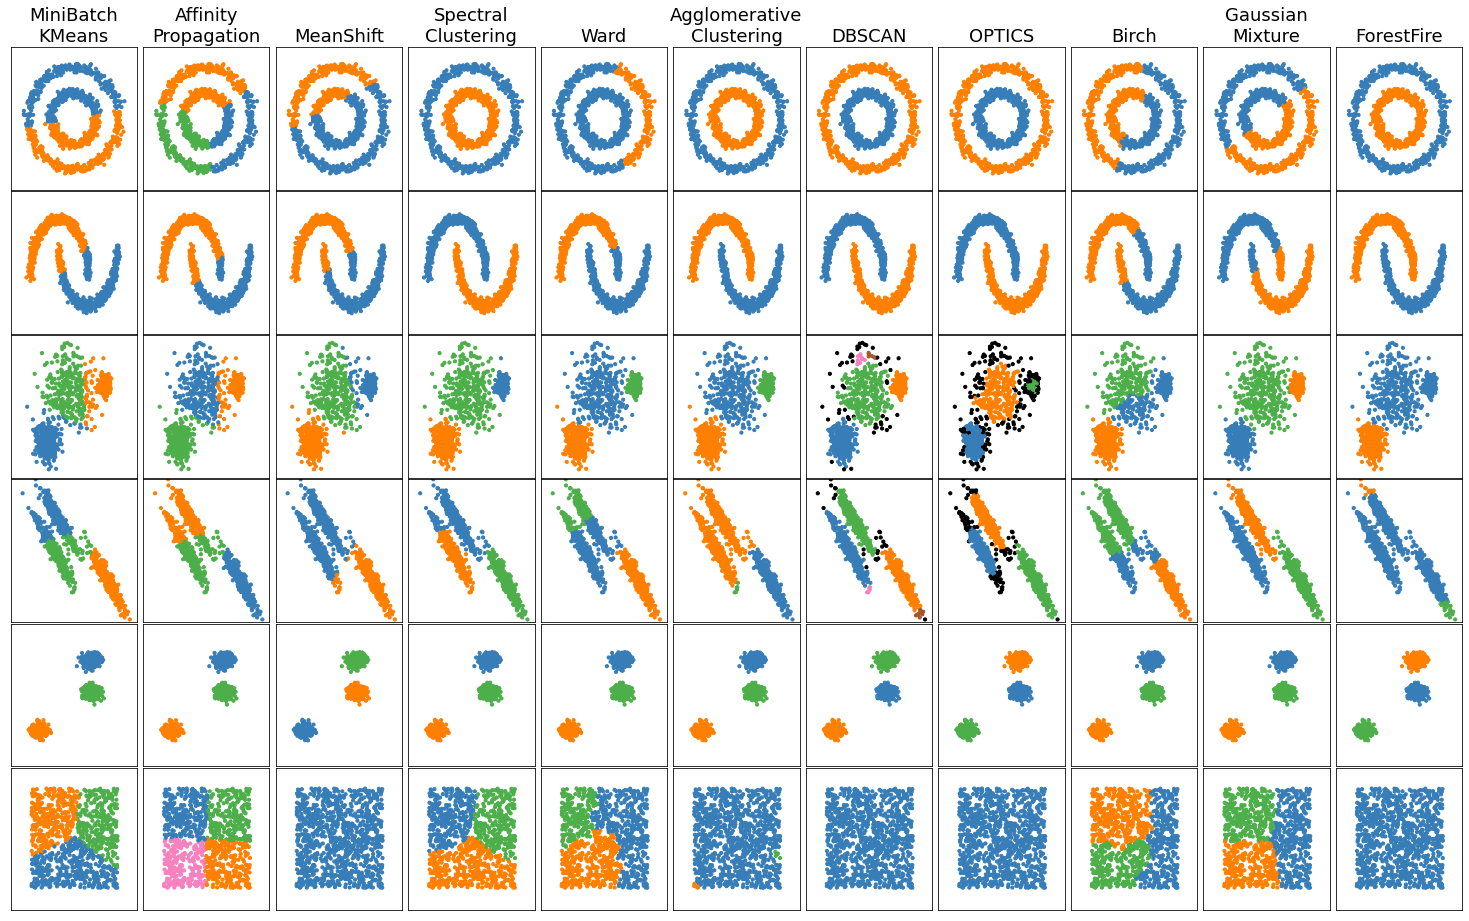

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('Gaussian\nMixture', gmm),
        ('ForestFire', forest_fire_clustering)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            if name == 'ForestFire':
                pass
            else:
                algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        elif name == "ForestFire":
            dist = compute_distances(X)
            affin = compute_affinity_matrix(dist, kernel_type='adaptive', k=15)
            y_pred = forest_fire_clustering(affin, fire_temp=12)
            y_pred = y_pred.astype(np.int)
            #print(y_pred)
            #print(type(y_pred))
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
#         plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
#                  transform=plt.gca().transAxes, size=15,
#                  horizontalalignment='right')
        plot_num += 1

plt.show()

## Silhouette Score Comparison

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5745566973301872
For n_clusters = 6 The average silhouette_score is : 0.43902711183132426


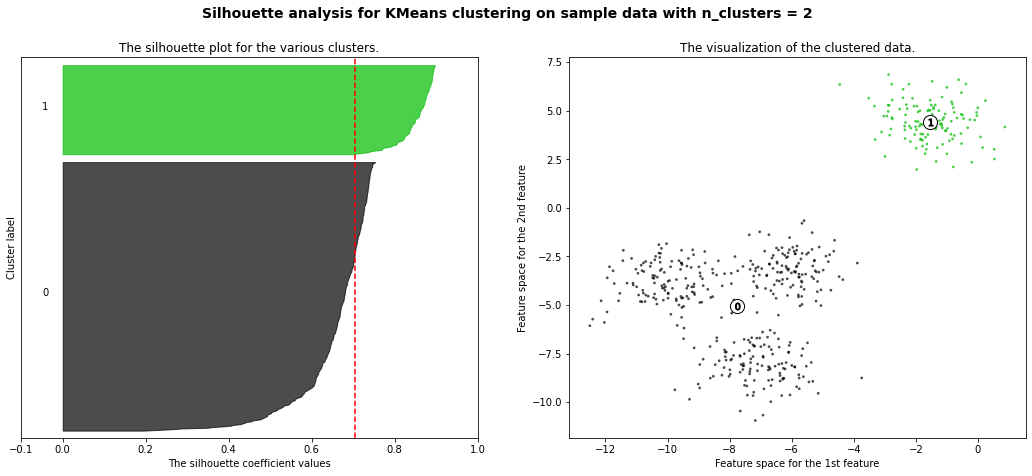

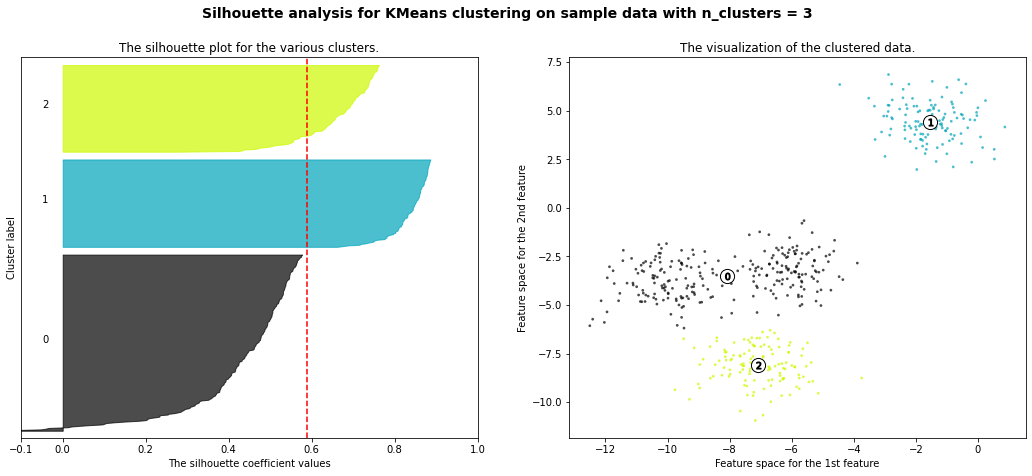

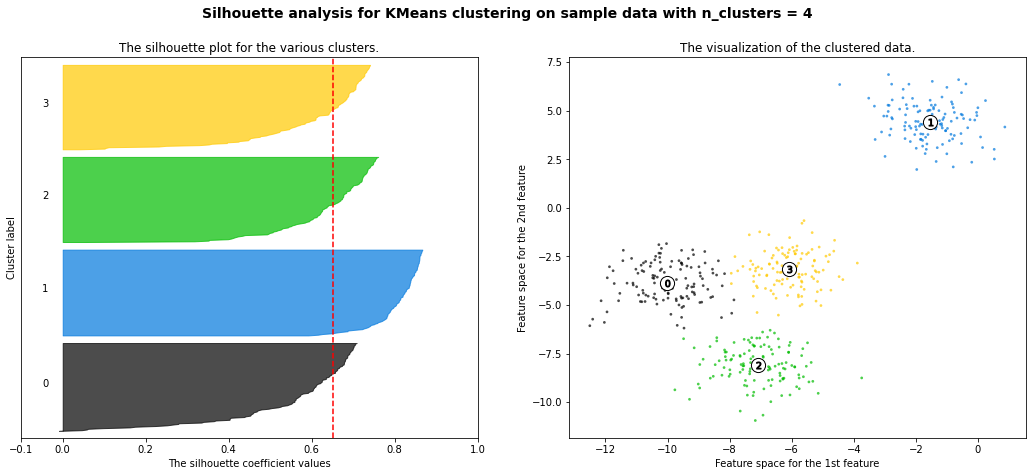

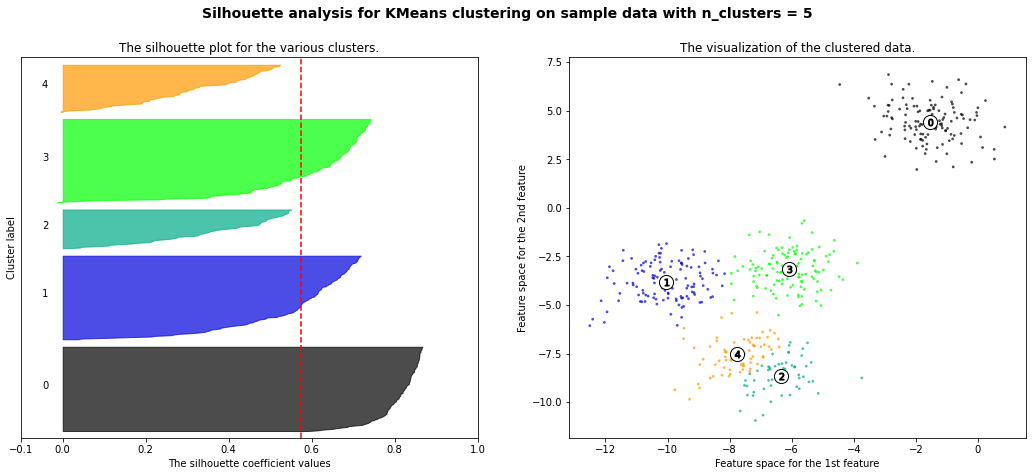

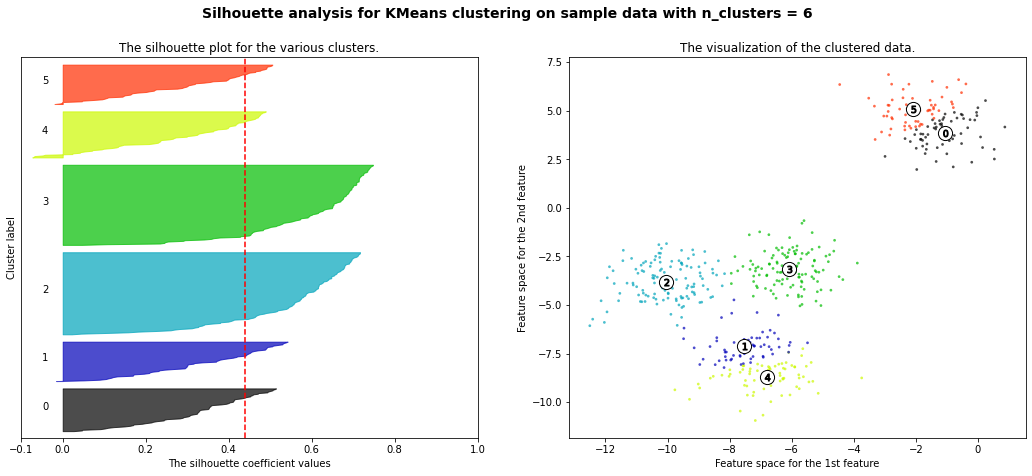

In [ ]:
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## The Wine Dataset
(from https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html)

In [ ]:
from sklearn.datasets import load_wine
data = load_wine(return_X_y = True)
X = data[0]
y = data[1]
wine_dist = compute_distances(X) 
wine_affin = compute_affinity_matrix(wine_dist, kernel_type='adaptive', k=5)

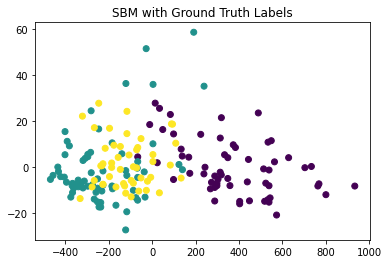

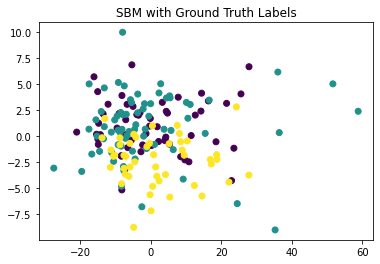

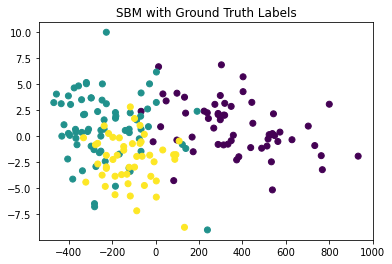

In [ ]:
pca_embedded = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
plt.figure()
plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c=y);
plt.title("SBM with Ground Truth Labels")
plt.show();

plt.figure()
plt.scatter(pca_embedded[:,1], pca_embedded[:,2], c=y);
plt.title("SBM with Ground Truth Labels")
plt.show();

plt.figure()
plt.scatter(pca_embedded[:,0], pca_embedded[:,2], c=y);
plt.title("SBM with Ground Truth Labels")
plt.show();

In [ ]:
output_labels = forest_fire_clustering(wine_affin, fire_temp=14)

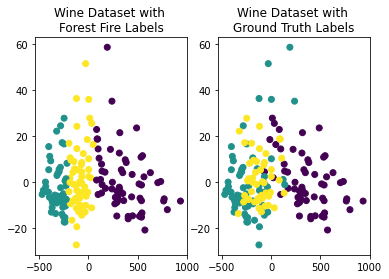

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c=output_labels);
plt.title("Wine Dataset with \nForest Fire Labels")
plt.subplot(1, 2, 2)
plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c=y);
plt.title("Wine Dataset with \nGround Truth Labels")
plt.show();

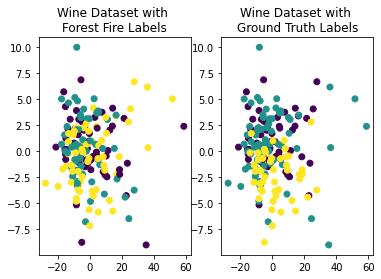

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(pca_embedded[:,1], pca_embedded[:,2], c=output_labels);
plt.title("Wine Dataset with \nForest Fire Labels")
plt.subplot(1, 2, 2)
plt.scatter(pca_embedded[:,1], pca_embedded[:,2], c=y);
plt.title("Wine Dataset with \nGround Truth Labels")
plt.show();

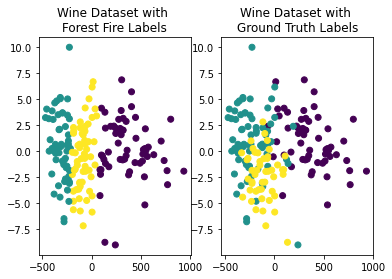

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(pca_embedded[:,0], pca_embedded[:,2], c=output_labels);
plt.title("Wine Dataset with \nForest Fire Labels")
plt.subplot(1, 2, 2)
plt.scatter(pca_embedded[:,0], pca_embedded[:,2], c=y);
plt.title("Wine Dataset with \nGround Truth Labels")
plt.show();